In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.manifold import TSNE

%matplotlib inline

# From Gaussian Algebra to Gaussian Processes

Most **introductory tutorials** on Gaussian processes start with a nose-punch of **fancy statements**, like:

- A Gaussian process (GP) defines a distribution over functions.
- A Gaussian process is non-parametric, i.e. it has an infinite number of parameters (duh?).
- Marginalizing a Gaussian over a subset of its elements gives another Gaussian.
- Conditioning a subset of the elements of a Gaussian on another subset of its elements gives another Gaussian.

They continue with **fancy terms**, like:

- Kernels
- Posterior over functions 
- Squared-exponentials
- Covariances

**Is this really supposed to make sense to the GP beginner?**

The following is the introductory tutorial on GPs that I wish I'd had myself. The goal is pedagogy — not the waving of **fancy words**.

By the end of this tutorial, you should understand:
- **What a Gaussian process is and how to build one in NumPy** — including those cool, swirly error blobs.
- **The motivations behind their functional form**, i.e. how the GP comes to be.
- The **fancy statements** above.
- The **fancy words** above.

Let's get started.

## Playing with Gaussians

Before moving within 500 nautical miles of the Gaussian process, we're going to start with something far easier: vanilla Gaussians themselves. This will help us to build intuition. **We'll arrive at the GP before you realize.**

The Gaussian distribution, a.k.a. the Normal distribution, can be thought of as a Python object which:

- Is instantiated with characteristic parameters `mu` (the mean) and `var` (the variance).
- Has a single public method, `density`, which accepts a `float` value `x`, and returns a `float` proportional to the probability of this `Gaussian` having produced `x`.

In [2]:
class Gaussian:
    
    def __init__(self, mu, var):
        self.mu = mu
        self.var = var
        self.stddev = np.sqrt(var)  # the standard deviation is the square-root of the variance
        
    def density(self, x):
        """
        NB: Understanding the two bullet points above is more important than understanding the following line.
        
        That said, it's just the second bullet in code, via SciPy.
        """
        return norm(loc=self.mu, scale=self.stddev).pdf(x)

So, how do we make those cool bell-shaped plots? **A 2D plot is just a list of tuples — each with an `x`, and a corresponding `y` — shown visually.**

As such, we lay out our `x`-axis, then compute the corresponding `y` — the `density` — for each. We'll choose an arbitrary `mu` and `variance`.

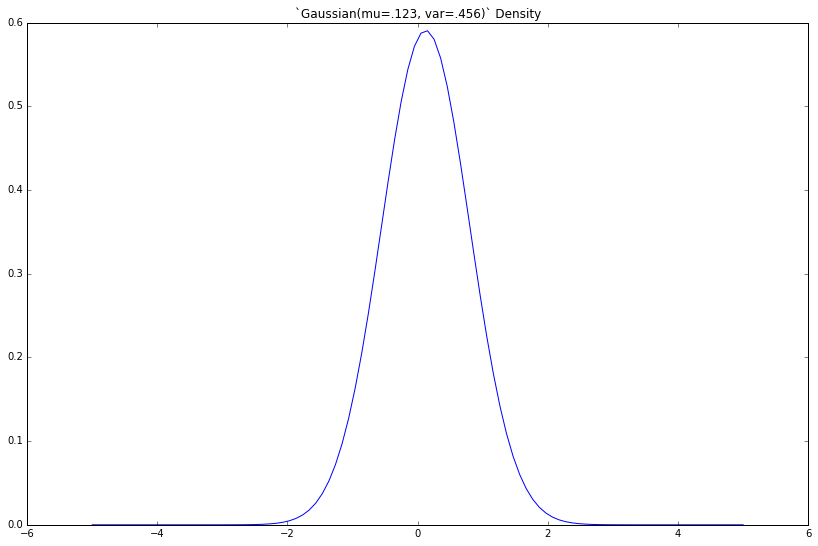

In [3]:
gaussian = Gaussian(mu=.123, var=.456)

x = np.linspace(-5, 5, 100)
y = [gaussian.density(xx) for xx in x]

plt.figure(figsize=(14, 9))
plt.plot(x, y)
_ = plt.title('`Gaussian(mu=.123, var=.456)` Density')

If we increase the variance `var`, what happens?

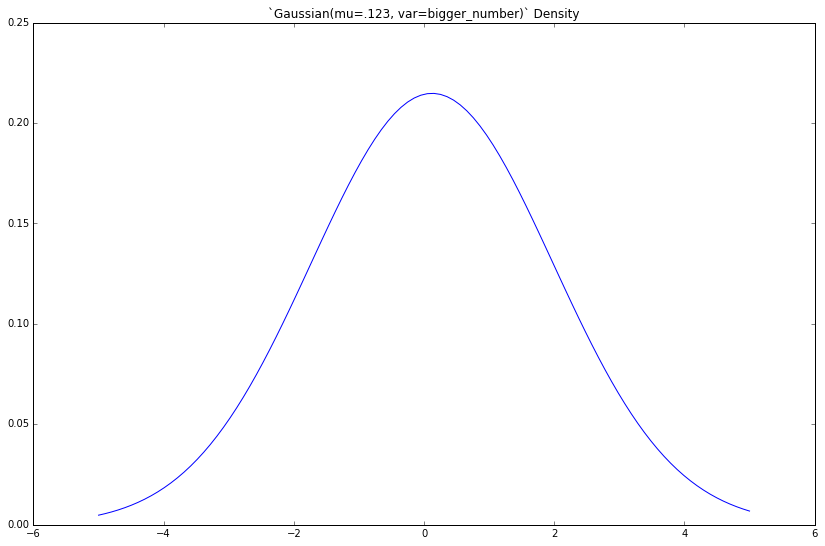

In [4]:
bigger_number = 3.45

gaussian = Gaussian(mu=.123, var=bigger_number)

x = np.linspace(-5, 5, 100)
y = [gaussian.density(xx) for xx in x]

plt.figure(figsize=(14, 9))
plt.plot(x, y)
_ = plt.title('`Gaussian(mu=.123, var=bigger_number)` Density')

The density gets fatter. This should be familiar to you.

Similarly, we can draw *samples* from a `Gaussian` distribution, e.g. from the initial `Gaussian(mu=.123, var=.456)` above. Its corresponding density plot (also above) governs this procedure, where `(x, y)` tuples give the (unnormalized) probability `y` that a given sample will take the value `x`. 

`x`-values with large corresponding `y`-values are more likely to be sampled. Here, values near .123 are most likely to be sampled. 

Let's add a method to our class, draw 500 samples, then plot their histogram.

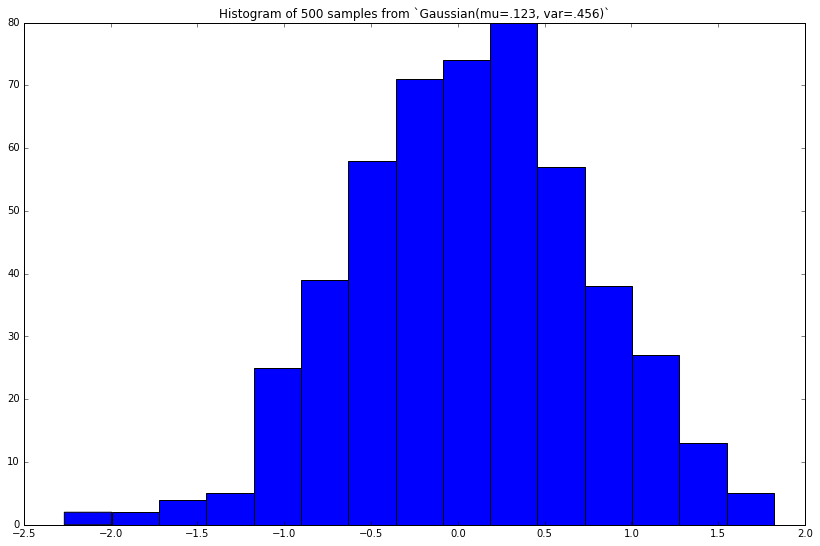

In [5]:
def sample(self):
    return norm(loc=self.mu, scale=self.stddev).rvs()


# Add method to class
Gaussian.sample = sample

# Instantiate new Gaussian
gaussian = Gaussian(mu=.123, var=.456)

# Draw samples
samples = [gaussian.sample() for _ in range(500)]

# Plot
plt.figure(figsize=(14, 9))
pd.Series(samples).hist(grid=False, bins=15)
_ = plt.title('Histogram of 500 samples from `Gaussian(mu=.123, var=.456)`')

This looks similar to the true `Gaussian(mu=.123, var=.456)` density we plotted above. The more random samples we draw (then plot), the closer this histogram will approximate (look similar to) the true density.

Now, we'll start to move a bit faster.

## 2D Gaussians

We just drew samples from a 1-dimensional Gaussian, i.e. the `sample` itself was a single float. The parameter `mu` dictated the most-likely value for the `sample` to assume, and the variance `var` dictated how much these sample-values vary (hence the name variance).

```python
>>> gaussian.sample()
-0.5743030051553177
>>> gaussian.sample()
0.06160509014194515
>>> gaussian.sample()
1.050830033400354
```

In 2D, each sample will be a list of two numbers. `mu` will dictate the most-likely pair of values for the `sample` to assume, and the second parameter (yet unnamed) will dictate:
1. How much the values in the first element of the list vary
2. How much the values in the second element of the list vary
3. How much the first and second elements vary with each other, e.g. if the first element is larger than expected, to what extent does the second element "follow suit" (and assume a value larger than expected as well)?

The second parameter is the **covariance matrix**, `cov`. The elements on the diagonal give Items 1 and 2. The elements off the diagonal give Item 3. The covariance matrix is always square, and its values are always non-negative.

Given a 2D `mu` and 2x2 `cov`, we can draw samples from the 2D Gaussian. Here, we'll use NumPy. Inline, we comment on the expected shape of the samples.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys


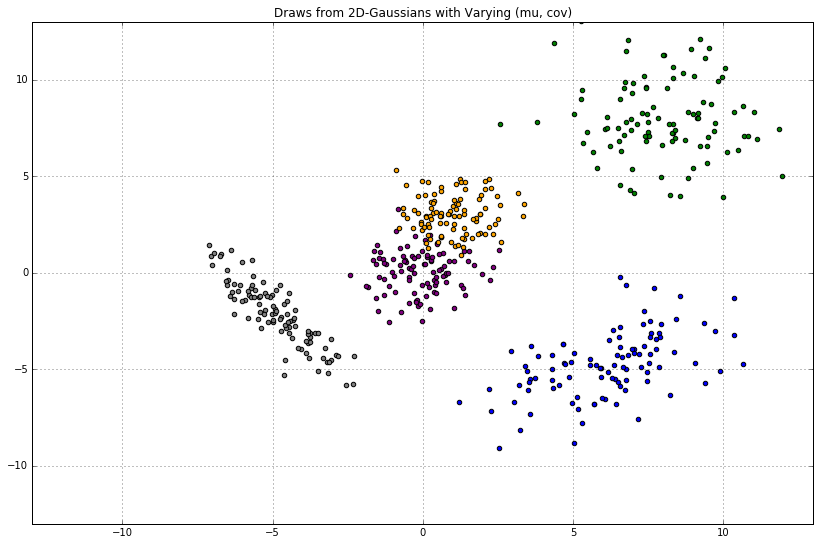

In [6]:
plt.figure(figsize=(14, 9))
plt.ylim(-13, 13)
plt.xlim(-13, 13)


def plot_2d_draws(mu, cov, color, n_draws=100):
    x, y = zip(*[np.random.multivariate_normal(mu, cov) for _ in range(n_draws)])
    plt.scatter(x, y, c=color)


"""
The purple dots should center around `(x, y) = (0, 0)`. `np.diag([1, 1])` gives the covariance matrix `[[1, 0], [0, 1]]`:
`x`-values have a variance of `var=1`; `y`-values have `var=1`; these values do not covary with one another
(e.g. if `x` is larger than its mean, the corresponding `y` has 0 tendency to "follow suit," i.e. trend larger than its 
mean as well).
"""
plot_2d_draws(
    mu=np.array([0, 0]),
    cov=np.diag([1, 1]),
    color='purple'
)

"""
The blue dots should center around `(x, y) = (1, 3)`. Same story with the covariance.
"""
plot_2d_draws(
    mu=np.array([1, 3]),
    cov=np.diag([1, 1]),
    color='orange'
)

"""
Here, the values along the diagonal of the covariance matrix are much larger: the cloud of green point should be much more
disperse. There is no off-diagonal covariance (`x` and `y` values do not vary — above or below their respective means — *together*).
"""
plot_2d_draws(
    mu=np.array([8, 8]),
    cov=np.diag([4, 4]),
    color='green'
)

"""
The covariance matrix has off-diagonal values of -2. This means that if `x` trends above its mean, `y` will tend to vary *twice as much,
but in the opposite direction, i.e. below its mean.*
"""
plot_2d_draws(
    mu=np.array([-5, -2]),
    cov=np.array([[1, -2], [-2, 3]]),
    color='gray'
)

"""
Covariances of 4.
"""

plot_2d_draws(
    mu=np.array([6, -5]),
    cov=np.array([[2, 4], [4, 2]]),
    color='blue'
)

_ = plt.title('Draws from 2D-Gaussians with Varying (mu, cov)')
plt.grid(True)

## Gaussians are closed under linear maps

The Gaussian for the blue dots tells us the following:

$$
(x, y) \sim \text{Normal}(\mu, \Sigma)
$$

In other words, the draws $(x, y)$ are distributed normally with 2D-mean $\mu$ and 2x2 covariance $\Sigma$.

Let's assume $(x, y)$ is a vector named $w$. Giving subscripts to the parameters of our Gaussian, we can rewrite the above as:

$$
w \sim \text{Normal}(\mu_w, \Sigma_w)
$$

Next, imagine we have some matrix $A$ of size 200x2. If $w$ is distributed as above, how is $Aw$ distributed? Gaussian algebra tells us the following:

$$
Aw \sim \text{Normal}(A\mu_w,\ A^T\Sigma_w A)
$$

In other words, $Aw$, the "linear map" of $w$ onto $A$, is (incidentally) Gaussian-distributed as well.

Let's plot some draws from this distribution. Let's assume each row of $A$ (of which there are 200, each containing 2 elements) is computed via the (arbitrary) function:

```python
def make_features(x):
    return np.array([3 * np.cos(x), np.abs(x - np.abs(x - 3))])
```

Now, how do we get $A$? Well, we could simply make such a matrix ourselves — `np.random.randn(200, 2)` for instance. Separately, imagine we start with a 200D vector $X$ of arbitrary floats, use the above function to make 2 "features" for each, then take the transpose. This gives us our 200x2 matrix $A$. Next, we'll multiply this matrix by our 2D vector of weights $\mu_w$. You can think of the latter as passing a batch of data through a linear model (where our data have features $x = [x_1, x_2]$, and our parameters are $w = [w_1, w_2]$).

Finally, we'll take draws from this $\text{Normal}(A\mu_w,\ A^T\Sigma_w A)$. This will give us tuples of the form `(x, y)`, where:
- `x` is the original `x`-value
- `y` is the value obtained after: making features out of $X$ and taking the transpose, giving $A$; taking the linear combination of $A$ with the mean-vector of weights; taking a draw from the multivariate-Gaussian we just defined, then plucking out the sample-element corresponding to `x`.

**Each draw from our Gaussian will yield 200 `y`-values, each corresponding to its original `x`. In other words, it will yield 200 `(x, y)` tuples — which we can plot.**

To make it clear that $A$ was computed as a function of $X$, let's rename it to $A = \phi(X)^T$, and rewrite our distribution as follows:

$$
w\phi(X)^T \sim \text{Normal}(\phi(X)^T\mu_w,\ \phi(X)^T\Sigma_w \phi(X))
$$

In addition, let's set $\mu_w =$ `np.array([0, 0])` and $\Sigma_w =$ np.diag([1, 2])`. Finally, we'll take draws, then plot.

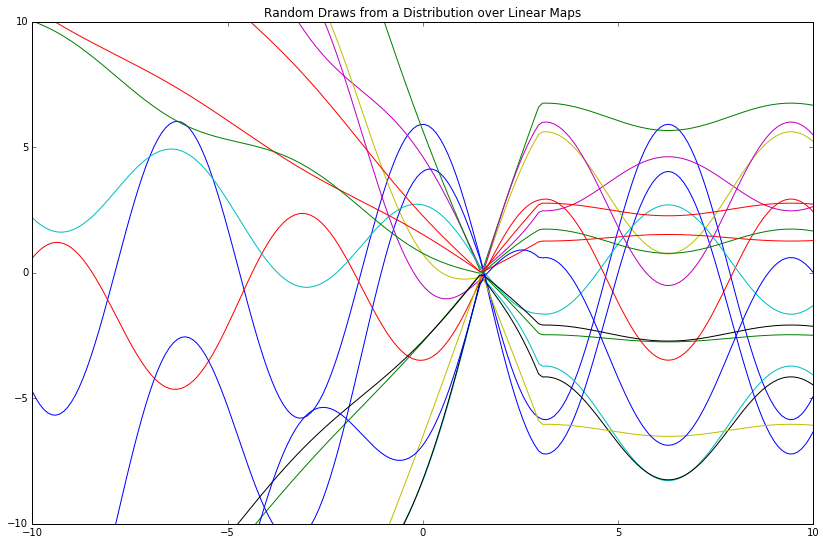

In [7]:
# x-values
x = np.linspace(-10, 10, 200)

# Make features, as before
phi_x = np.array([3 * np.cos(x), np.abs(x - np.abs(x - 3))])  # phi_x.shape: (2, len(x))

# Params of distribution over weights
mu_w = np.array([0, 0])
cov_w = np.diag([1, 2])

# Params of distribution over linear map (lm)
mu_lm = phi_x.T @ mu_w
cov_lm = phi_x.T @ cov_w @ phi_x

plt.figure(figsize=(14, 9))
plt.ylim(-10, 10)
plt.xlim(-10, 10)
plt.title('Random Draws from a Distribution over Linear Maps')

for _ in range(17):
    # Plot draws. `lm` is a vector of 200 `y` values, each corresponding to the original `x`-values
    lm = np.random.multivariate_normal(mu_lm, cov_lm)  # lm.shape: (200,)
    plt.plot(x, lm)

**This distribution over linear maps gives a distribution over functions**, where the "mean function" is $\phi(X)^T\mu_w$ (which reads directly from the `mu_lm` variable above).

**Notwithstanding, I find this phrasing to be confusing**; to me, a "distribution over functions" sounds like some opaque object that spits out algebraic symbols via logic miles above my cognitive ceiling. As such, I instead think of this in more intuitive terms, as a **distribution over function evaluations**: a vector of floats $y$, where each $y_i$ corresponds to its initial input $x_i$.

For example, given a vector `x = np.array([1, 2, 3])` and a function `lambda x: x**2`, an evaluation of this function gives `y = np.array([1, 4, 9])`. We now have tuples `[(1, 1), (2, 4), (3, 9)]`, which we can plot. This gives one "function evaluation."

Above, we did this 17 times then plotted the 200 resulting `(x, y)` tuples (as our input was a 200D vector $X$). This gave 17 curves. The curves are similar because of the given mean function `mu_lm`; they are different because of the given covariance matrix `cov_lm`.

Let's try some different "features" for our x-values then plot the same thing.

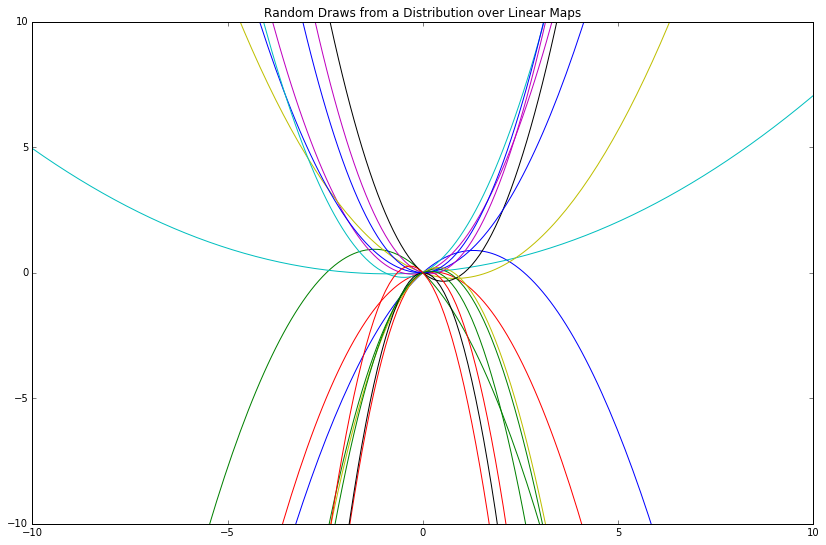

In [8]:
# x-values
x = np.linspace(-10, 10, 200)

# Make different, though still arbitrary, features
phi_x = np.array([x ** (1 + i) for i in range(2)])

# Params of distribution over weights
mu_w = np.array([0, 0])
cov_w = np.diag([1, 2])

# Params of distribution over linear map (lm)
mu_lm = mu_w.T @ phi_x
cov_lm = phi_x.T @ cov_w @ phi_x

plt.figure(figsize=(14, 9))
plt.ylim(-10, 10)
plt.xlim(-10, 10)
plt.title('Random Draws from a Distribution over Linear Maps')

for _ in range(17):
    # Plot draws. `lm` is a vector of 200 `y` values, each corresponding to the original `x`-values
    lm = np.random.multivariate_normal(mu_lm, cov_lm)  # lm.shape: (200,)
    plt.plot(x, lm)

The features we choose give a "language" with which we can express a relationship between $x$ and $y$. Some features are more expressive than others; ome restrict us entirely from expressing certain relationships.

For further illustration, let's employ step functions as features and see what happens.

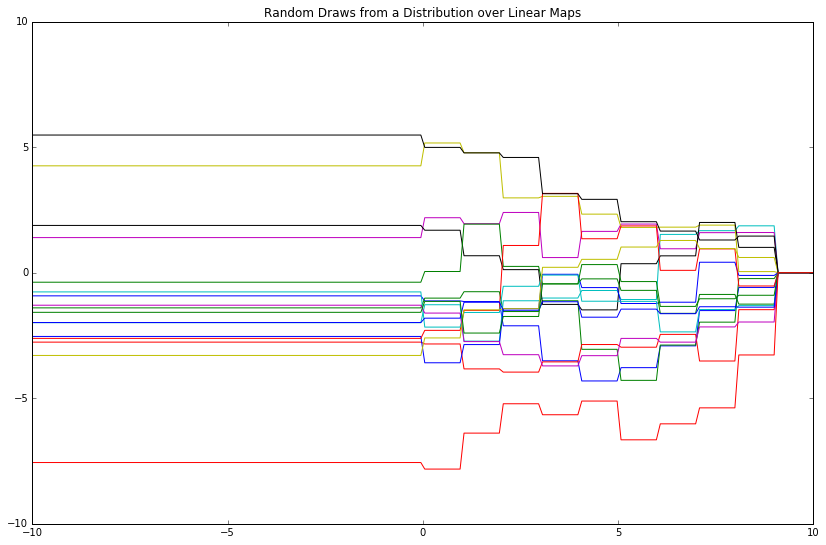

In [9]:
# x-values
x = np.linspace(-10, 10, 200)

# Make features, as before
phi_x = np.array([x < i for i in range(10)])

# Params of distribution over weights
mu_w = np.zeros(10)
cov_w = np.eye(10)

# Params of distribution over linear map (lm)
mu_lm = mu_w.T @ phi_x
cov_lm = phi_x.T @ cov_w @ phi_x

plt.figure(figsize=(14, 9))
plt.ylim(-10, 10)
plt.xlim(-10, 10)
plt.title('Random Draws from a Distribution over Linear Maps')

for _ in range(17):
    # Plot draws. `lm` is a vector of 200 `y` values, each corresponding to the original `x`-values
    lm = np.random.multivariate_normal(mu_lm, cov_lm)  # lm.shape: (200,)
    plt.plot(x, lm)

## Gaussians are closed under conditioning and marginalization

Let's revisit the 2D Gaussians plotted above. They took the form:

$$
(x, y) \sim \mathcal{N}(\mu, \Sigma)
$$

Said differently:

$$
P(x, y) = \mathcal{N}(\mu, \Sigma)
$$

And now a bit more rigorously:

$$
P(x, y) = \mathcal{N}\bigg([\mu_x, \mu_y], 
    \begin{bmatrix}
    \Sigma_x & \Sigma_{xy}\\
    \Sigma_{xy}^T & \Sigma_y\\
    \end{bmatrix}\bigg)
$$

**NB: In this case, all 4 "Sigmas" in the 2x2 covariance matrix are scalars. If our covariance were bigger, say 31x31, but we still wrote it as we did above, then these 4 "Sigmas" would be *matrices* (with an aggregate size totalling 31x31).**

What if we wanted to know the distribution over $y$ conditional on $x$ taking on a certain value, e.g. $P(y\vert x > 1)$?

$y$ is a single element, so the resulting conditional will be a univariate distribution. To gain intuition, let's do this in a very crude manner:

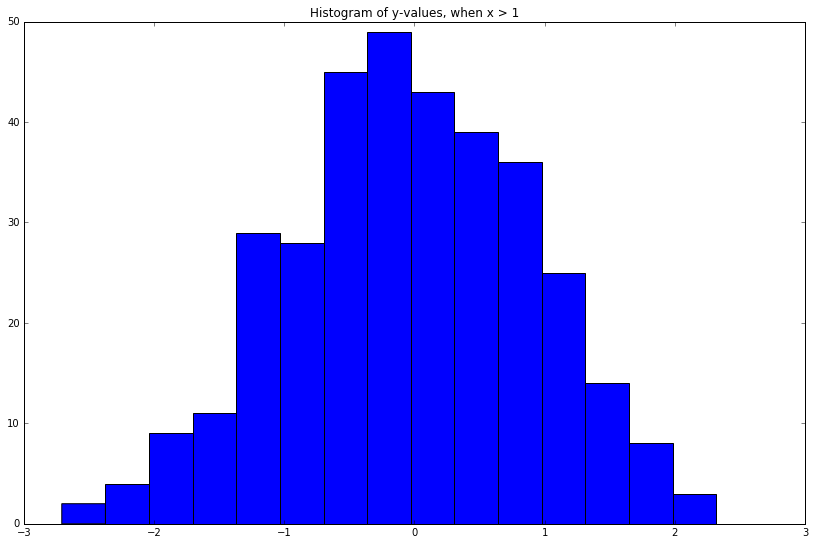

In [10]:
y_values = []
mu, cov = np.array([0, 0]), np.diag([1, 1])
while len(y_values) < 345:
    x, y = np.random.multivariate_normal(mu, cov)
    if x > 1:
        y_values.append(y)

plt.figure(figsize=(14, 9))
pd.Series(y_values).hist(grid=False, bins=15)
_ = plt.title('Histogram of y-values, when x > 1')

Cool! Looks kind of Gaussian as well.

Instead, what if we wanted to know the functional form of the real density, $P(y\vert x)$, instead of this empirical distribution of its samples? One of the axioms of conditional probability tells us that:

$$
P(y\vert x) = \frac{P(x, y)}{P(x)} = \frac{P(x, y)}{\int P(x, y)dy}
$$

The right-most denominator can be written as:

$$
\begin{align*}
\int P(x, y)dy 
    &= \int \mathcal{N}\bigg([\mu_x, \mu_y], 
        \begin{bmatrix}
        \Sigma_x & \Sigma_{xy}\\
        \Sigma_{xy}^T & \Sigma_y\\
        \end{bmatrix}\bigg)
   dy\\
   \\
   &= \mathcal{N}(\mu_x, \Sigma_x)
\end{align*}
$$

**Marginalizing a > 1D Gaussian over one of its elements yields another Gaussian**: you just "pluck out" the elements you'd like to examine. **In other words, Gaussians are closed under marginalization.** It's almost too easy to warrant a formula.

As an example, imagine we had the following Gaussian, and wanted to compute the marginal over the first 2 elements:

```python

# 3D Gaussian
mu = np.array([3, 5, 9])
cov = np.array([
    [11, 22, 33],
    [44, 55, 66],
    [77, 88, 99]
])

# Marginal over the first 2 elements
mu_marginal = np.array([3, 5])
cov_marginal = np.array([
    [11, 22],
    [44, 55]
])

# That's it.

```

Finally, we compute the conditional Gaussian of interest — a result well-documented by mathematicians long ago:

$$
\begin{align*}
P(y\vert x)
    &= \frac{
            \mathcal{N}\bigg(
                [\mu_x, \mu_y], 
                \begin{bmatrix}
                \Sigma_x & \Sigma_{xy}\\
                \Sigma_{xy}^T & \Sigma_y\\
                \end{bmatrix}
            \bigg)
            }
            {\mathcal{N}(\mu_x, \Sigma_x)}\\
   \\
   &= \mathcal{N}(\mu_y + \Sigma_{xy}\Sigma_x^{-1}(x - \mu_x), \Sigma_y - \Sigma_{xy}\Sigma_x^{-1}\Sigma_{xy}^T)
\end{align*}
$$
 
$x$ can be a matrix. From there, just plug stuff in.

Conditioning a > 1D Gaussian on one (or more) of its elements yields another Gaussian. **In other words, Gaussians are closed under conditioning.**

## Inferring the weights

We previously posited a distribution over some vector of weights, $w \sim \text{Normal}(\mu_w, \Sigma_w)$. In addition, we posited a distribution over the linear map of these weights onto some matrix $A = \phi(X)^T$:

$$
w\phi(X)^T \sim \text{Normal}(\phi(X)^T\mu_w,\ \phi(X)^T\Sigma_w \phi(X))
$$

Given some ground-truth realizations from this distribution $y$, i.e. ground-truth "function evaluations," we'd like to infer the weights $w$ most consistent with these values. 

*In machine learning, we equivalently say that given a model and some observed data `(X_train, y_train)`, we compute/train/infer/optimize the weights of said model (often via backpropagation).*

Most precisely, our goal is to infer $P(w\vert y)$ (where $y$ are our observed function evaluations). To do this, we simply posit a joint distribution over both quantities:

$$
P(w, y) =
    \mathcal{N}\bigg(
        [\mu_w, \phi(X)^T\mu_w], 
        \begin{bmatrix}
        \Sigma_w & \Sigma_{wy}\\
        \Sigma_{wy}^T & \phi(X)^T\Sigma_w \phi(X)\\
        \end{bmatrix}
    \bigg)
$$

Then compute the conditional via the formula above:

$$
\begin{align*}
P(w\vert y) 
    &= \mathcal{N}(\mu_w + \Sigma_{wy}\Sigma_y^{-1}(y - \mu_y), \Sigma_w - \Sigma_{wy}\Sigma_y^{-1}\Sigma_{wy}^T)\\
    \\
    &= \mathcal{N}(\mu_w + \Sigma_{wy}(\phi(X)^T\Sigma_w \phi(X))^{-1}(y - \mu_w^T \phi(X)), \Sigma_w - \Sigma_{wy}(\phi(X)^T\Sigma_w \phi(X))^{-1}\Sigma_{wy}^T)
\end{align*}
$$

This formula gives the posterior distribution over our weights given the model and observed data tuples `(x, y)`.

Until now, we've assumed a 2D $w$, and therefore a $\phi(X)$ in $\mathbb{R}^2$ as well. Moving forward, let's work with weights and features in $\mathbb{R}^{20}$ which will give us a more expressive language with which to capture the true relationship between some quantity $x$ and its corresponding $y$. $\mathbb{R}^{20}$ is an arbitrary choice.

In [11]:
# The true function that maps `x` to `y`. This is what we are trying to recover with our mathematical model.
def true_function(x):
    return np.sin(x)**2 - np.abs(x - 3) + 7


# x-values
x_train = np.array([-5, -2.5, -1, 2, 4, 6])


# y-train
y_train = true_function(x_train)


# Params of distribution over weights
D = 20
mu_w = np.zeros(D)  # mu_w.shape: (D,)
cov_w = 1.1 * np.diag(np.ones(D))  # cov_w.shape: (D, D)


# A function to make some arbitrary features
def phi_func(x):
    return np.array([np.abs(x - d) for d in range(int(-D / 2), int(D / 2))])  # phi_x.shape(D, len(x))


# A function that computes the parameters of the linear map distribution
def compute_linear_map_params(mu, cov, map_matrix):
    mu_lm = mu.T @ map_matrix
    cov_lm = map_matrix.T @ cov @ map_matrix
    return mu_lm, cov_lm


def compute_weights_posterior(mu_w, cov_w, phi_func, x_train, y_train):
    """
    NB: "Computing a posterior," and given that that posterior is Gaussian, implies nothing more than
    computing the mean-vector and covariance matrix of this Gaussian.
    """
    # Featurize x_train
    phi_x = phi_func(x_train)
    
    # Params of prior distribution over function evals
    mu_y, cov_y = compute_linear_map_params(mu_w, cov_w, phi_x)

    # Params of posterior distribution over weights
    mu_w_post = mu_w + cov_w @ phi_x @ np.linalg.inv(cov_y) @ (y_train - mu_y)
    cov_w_post = cov_w - cov_w @ phi_x @ np.linalg.inv(cov_y) @ phi_x.T @ cov_w
    
    return mu_w_post, cov_w_post
  

# Compute weights posterior
mu_w_post, cov_w_post = compute_weights_posterior(mu_w, cov_w, phi_func, x_train, y_train)

As with our prior over our weights, we can equivalently draw samples from the posterior, then plot. These samples will be 20D vectors; we reduce them to 2D for ease of visualization.

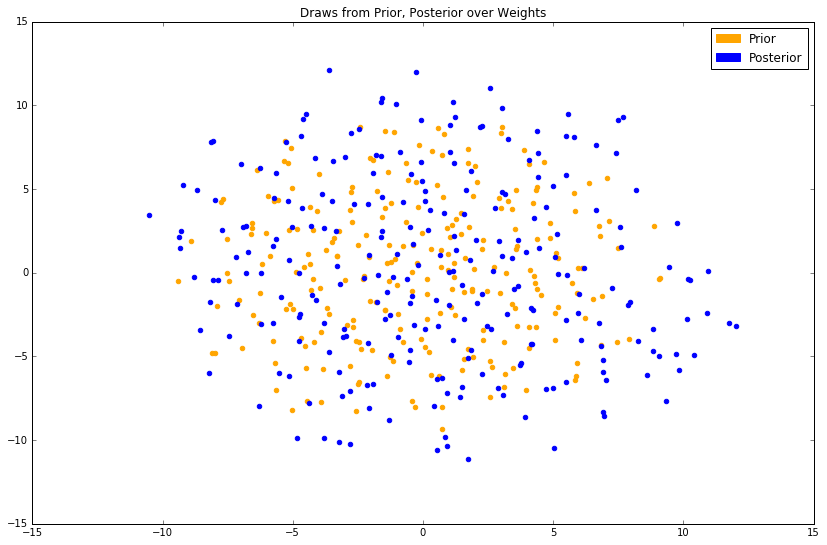

In [12]:
# Draw samples
samples_prior = np.random.multivariate_normal(mu_w, cov_w, size=250)
samples_post = np.random.multivariate_normal(mu_w_post, cov_w_post, size=250)

# Reduce to 2D for ease of plotting
first_dim_prior, second_dim_prior = zip(*TSNE(n_components=2).fit_transform(samples_prior))
first_dim_post, second_dim_post = zip(*TSNE(n_components=2).fit_transform(samples_post))

# Plot prior, posterior draws
plt.figure(figsize=(14, 9))
plt.title('Draws from Prior, Posterior over Weights')
plt.legend(handles=[
    mpatches.Patch(color='orange', label='Prior'),
    mpatches.Patch(color='blue', label='Posterior'),
])

plt.scatter(first_dim_prior, second_dim_prior, color='orange')
plt.scatter(first_dim_post, second_dim_post, color='blue')

Samples from the prior are plotted in orange; samples from the posterior are plotted in blue. As this is a stochastic dimensionality-reduction algorithm, the results will be slightly different each time.

At best, we can see that the posterior has slightly larger values in its covariance matrix, and has probably maintained a similar mean. This type of change (read: a small one) is expected, as we've only conditioned on 6 ground-truth tuples.

# Predicting on new data

We'd now like to sample new function evaluations given the updated distribution (i.e. posterior distribution) over weights. Previously, we generated these samples by centering a multivariate Gaussian on $\phi(x)^T\mu_{w}$, where $\mu_w$ was the mean of the prior distribution over weights. How do we do this with our posterior over weights instead?

**Well, Gaussians are closed under linear maps.** So, we just follow the formula we had used above.

This time, instead of input vector $X$, we'll use a new input vector called $X_{*}$.

$$
\phi(X_{*})^Tw \sim \text{Normal}(\phi(X_{*})^T\mu_{w, \text{post}},\ \phi(X_{*})^T \Sigma_{w, \text{post}}\phi(X_{*}))
$$

**This gives us a posterior distribution over function evaluations.**

In machine learning parlance, this is akin to: given some test data `X_test`, and a model whose weights were trained/optimized with respect to/conditioned on some observed ground-truth tuples `(X_train, y_train)`, we'd like to generate predictions `y_test`, i.e. samples from the posterior over function evaluations.

The function to compute this posterior, i.e. compute the mean-vector and covariance matrix of this Gaussian, will appear both short and familiar.

In [13]:
x_test = np.linspace(-10, 10, 200)


def compute_gp_posterior(mu_w, cov_w, phi_func, x_train, y_train, x_test):
    mu_w_post, cov_w_post = compute_weights_posterior(mu_w, cov_w, phi_func, x_train, y_train)
    phi_x_test = phi_func(x_test)
    mu_y_post, cov_y_post = compute_linear_map_params(mu_w_post, cov_w_post, phi_x_test)
    return mu_y_post, cov_y_post


mu_y_post, cov_y_post = compute_gp_posterior(mu_w, cov_w, phi_func, x_train, y_train, x_test)

To plot, we typically just plot the error bars, i.e. the space within `(mu_y_post - var_y_post, mu_y_post + var_y_post)` for each `x`, as well as the ground-truth tuples as big red dots. **This gives nothing more than a picture of the mean-vector and covariance of our posterior.** Optionally, we can plot true function evaluations from this posterior as well, as we did with our prior.

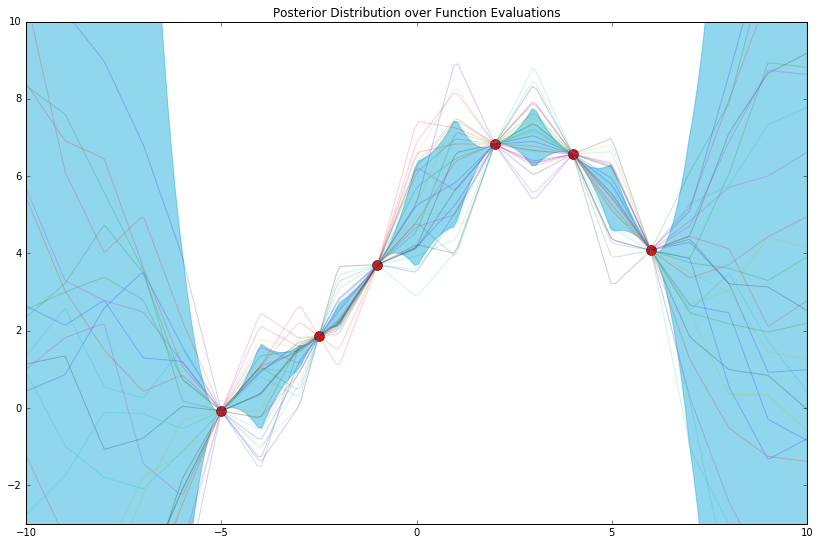

In [14]:
def plot_gp_posterior(mu_y_post, cov_y_post, x_train, y_train, x_test, n_samples=0, ylim=(-3, 10)):
    plt.figure(figsize=(14, 9))
    plt.ylim(*ylim)
    plt.xlim(-10, 10)
    plt.title('Posterior Distribution over Function Evaluations')

    # Extract the variances, i.e. the diagonal, of our covariance matrix
    var_y_post = np.diag(cov_y_post)

    # Plot the error bars. To do this, we fill the space between `(mu_y_post - var_y_post, mu_y_post + var_y_post)` for each `x`
    plt.fill_between(x_test, mu_y_post - var_y_post, mu_y_post + var_y_post, color='#23AEDB', alpha=.5)  # plot error bars

    # Scatter-plot our original 6 `(x, y)` tuples
    plt.plot(x_train, y_train, 'ro', markersize=10)  # plot ground-truth `(x, y)` tuples

    # Optionally plot actual function evaluations from this posterior
    if n_samples > 0:
        for _ in range(n_samples):
            y_pred = np.random.multivariate_normal(mu_y_post, cov_y_post)
            plt.plot(x_test, y_pred, alpha=.2)


plot_gp_posterior(mu_y_post, cov_y_post, x_train, y_train, x_test, n_samples=25)

The posterior distribution is nothing more than a distribution over function evaluations (25 of which are shown above) *most consistent with our model and observed data tuples.* As such, and to give further intuition, a crude way of computing this distribution might be continuously *drawing samples from our prior over function evaluations, and keeping only the ones that pass through, i.e. are "most consistent with," all of the red points above.*

Finally, we stated before that **the features we choose (i.e. our `phi_func`) give a "language" with which we can express the relationship between $x$ and $y$.** Here, we've chosen a language with 20 words. What if we chose a different 20?

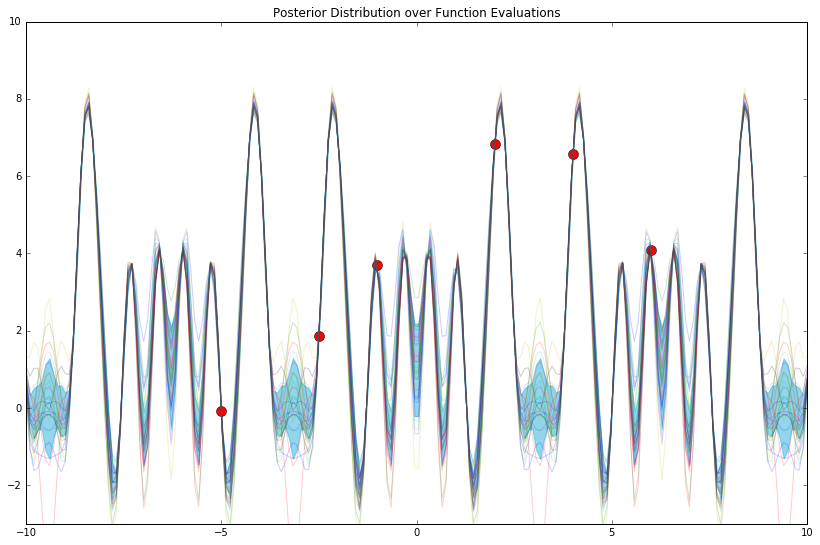

In [15]:
D = 20


# Params of distribution over weights
mu_w = np.zeros(D)  # mu_w.shape: (D, )
cov_w = 1.1 * np.diag(np.ones(D))  # cov_w.shape: (D, D)


# Still arbitrary, i.e. a modeling choice!
def phi_func(x, D=D, a=.25):
    return np.array([a * np.cos(i * x) for i in range(int(-D / 2), int(D / 2))])  # phi_x.shape: (D, len(x))


mu_y_post, cov_y_post = compute_gp_posterior(mu_w, cov_w, phi_func, x_train, y_train, x_test)
plot_gp_posterior(mu_y_post, cov_y_post, x_train, y_train, x_test, n_samples=25)

Not great. As a brief aside, how do we read the plot above? It's simply a function, a transformation, a lookup: given an $x$, it tells us the corresponding expected value $y$, and the variance around this estimate.

For instance, right around $x = -3$, we can see that $y$ is somewhere in $[-1, 1]$; given that we've only conditioned on 6 "training points," we're still quite unsure as to what the true answer is. To this effect, a GP (and other fully-Bayesian models) allows us to quantify this uncertainty judiciously.

Now, let's try some more features and examine the model we're able to build.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: covariance is not positive-semidefinite.


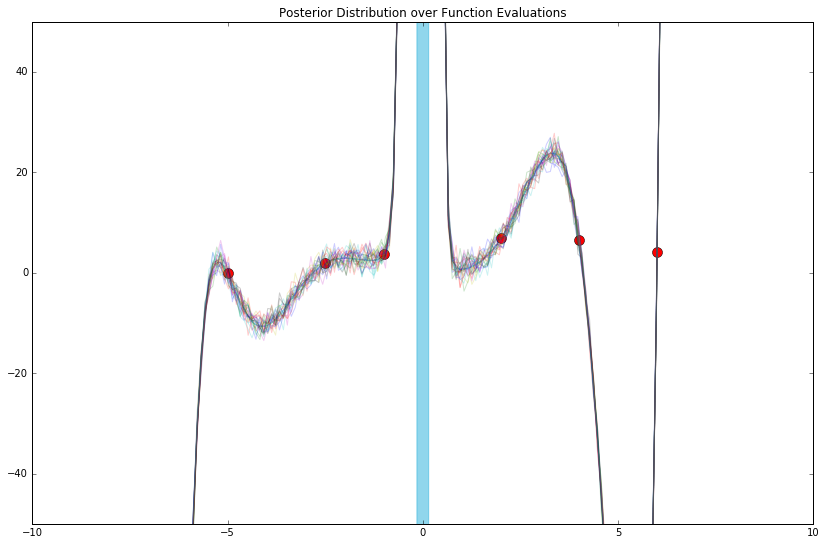

In [16]:
D = 20


# Params of distribution over weights
mu_w = np.zeros(D)  # mu_w.shape: (D, )
cov_w = 1.1 * np.diag(np.ones(D))  # cov_w.shape: (D, D)


# Still arbitrary, i.e. a modeling choice!
def phi_func(x, D=D, a=1e-5):
    return np.array([a * (x ** i) for i in range(int(-D / 2), int(D / 2))])  # phi_x.shape: (D, len(x))


mu_y_post, cov_y_post = compute_gp_posterior(mu_w, cov_w, phi_func, x_train, y_train, x_test)
plot_gp_posterior(mu_y_post, cov_y_post, x_train, y_train, x_test, n_samples=25, ylim=(-50, 50))

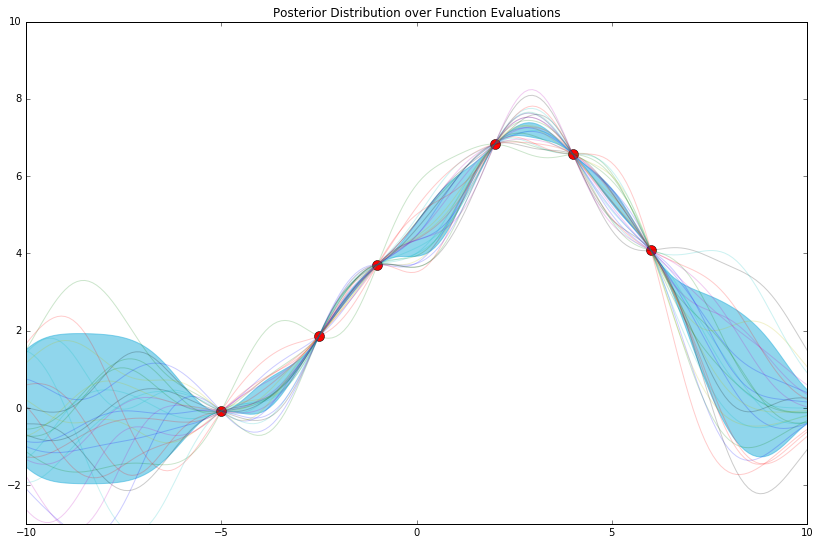

In [17]:
D = 20


# Params of distribution over weights
mu_w = np.zeros(D)  # mu_w.shape: (D, )
cov_w = 1.1 * np.diag(np.ones(D))  # cov_w.shape: (D, D)


def phi_func(x, D=D):
    return np.array([np.exp(-.5 * (x - d)**2) for d in range(int(-D / 2), int(D / 2))])  # phi_x.shape: (D, len(x))


mu_y_post, cov_y_post = compute_gp_posterior(mu_w, cov_w, phi_func, x_train, y_train, x_test)
plot_gp_posterior(mu_y_post, cov_y_post, x_train, y_train, x_test, n_samples=25)

That last one might look familiar. Therein, the features we chose (and really, still arbitrarily) are called "radial basis functions" (among other names).

We've loosely examined when we change the language through which we can express our model. Next, what if we changed the size of its vocabulary?

First, let's backtrack, and try 8 of these radial basis functions instead of 20.

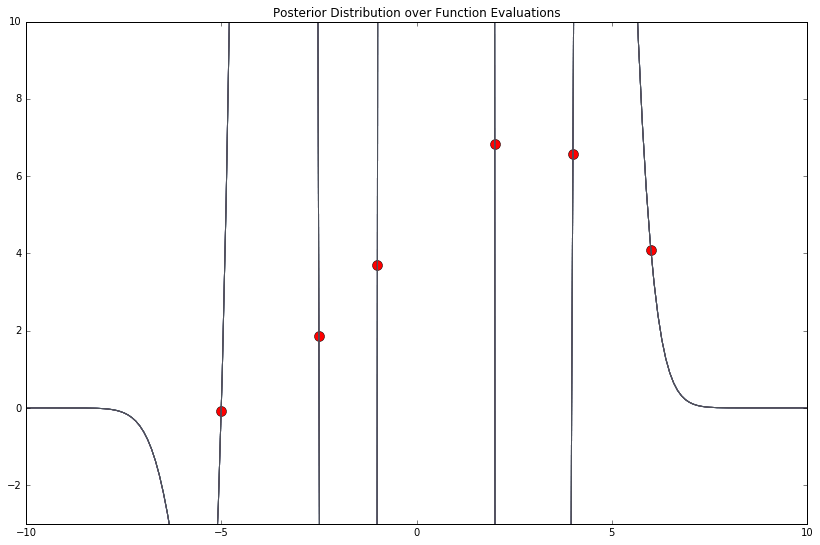

In [18]:
D = 8


# Params of distribution over weights
mu_w = np.zeros(D)  # mu_w.shape: (D, )
cov_w = 1.1 * np.diag(np.ones(D))  # cov_w.shape: (D, D)


def phi_func(x, D=D):
    return np.array([np.exp(-.5 * (x - d)**2) for d in range(int(-D / 2), int(D / 2))])  # phi_x.shape: (D, len(x))


mu_y_post, cov_y_post = compute_gp_posterior(mu_w, cov_w, phi_func, x_train, y_train, x_test)
plot_gp_posterior(mu_y_post, cov_y_post, x_train, y_train, x_test, n_samples=25)

Very different! Holy overfit. What about 250?

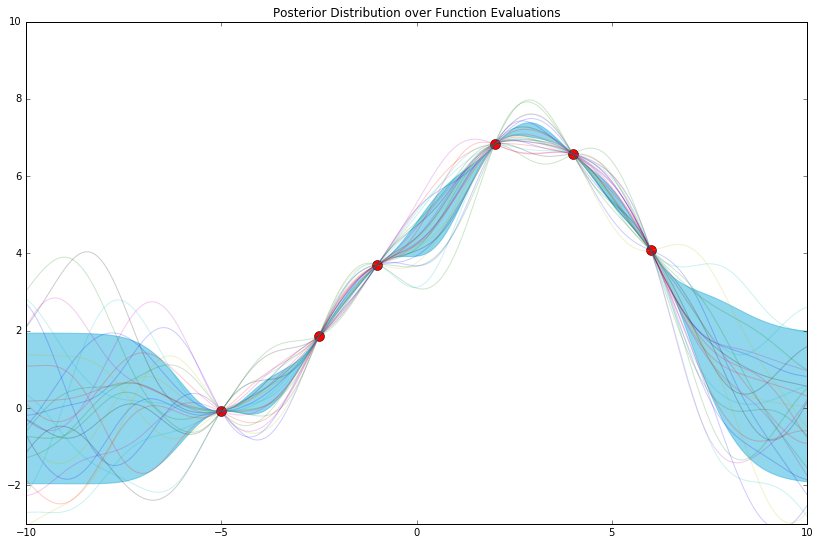

In [19]:
D = 250


# Params of distribution over weights
mu_w = np.zeros(D)  # mu_w.shape: (D, )
cov_w = 1.1 * np.diag(np.ones(D))  # cov_w.shape: (D, D)


def phi_func(x, D=D):
    return np.array([np.exp(-.5 * (x - d)**2) for d in range(int(-D / 2), int(D / 2))])  # phi_x.shape: (D, len(x))


mu_y_post, cov_y_post = compute_gp_posterior(mu_w, cov_w, phi_func, x_train, y_train, x_test)
plot_gp_posterior(mu_y_post, cov_y_post, x_train, y_train, x_test, n_samples=25)

It appears that the more features we use, the more expressive, and/or less endemically prone to overfitting, our model becomes.

So, how far do we take this? `D = 1000`? `D = 50000`? How high can we go? **We'll pick up here in the next post.**

# Summary

In this tutorial, we've arrived at the mechanical notion of a Gaussian process via simple Gaussian algebra, and a bit of Gaussian calculus. 

**Thus far, we've elucidated the following ideas:**

- A Gaussian process (GP) defines a distribution over functions (i.e. function evaluations). √
- Marginalizing a Gaussian over a subset of its elements gives another Gaussian (just pluck out the pieces of interest). √
- Conditioning a subset of the elements of a Gaussian on another subset gives another Gaussian (a simple algebraic formula). √
- Posterior over functions (the linear map of the posterior over weights onto some matrix $A = \phi(X)^T$) √
- Covariances (the second thing we need in order to specify a multivariate Gaussian) √

**Conversely, we did not yet cover (directly):**

- Kernels
- Squared-exponentials
- A Gaussian process is non-parametric, i.e. it has an infinite number of parameters (duh?).

These will be the subject of the following post.

Thanks for reading, and don't let arcane pedagogy discourage you. There's almost always a clearer explanation at bay.